In [1]:

%matplotlib inline
from matplotlib import pyplot
import geopandas
from shapely.affinity import translate
from shapely.affinity import rotate
import shapely.wkt

from tile_units import TileUnit
from tile_map import Tiling

In [2]:
ak = geopandas.read_file("../data/imd-auckland-2018.gpkg")

# Cairo tiles
The one true tiling. Provides 4 directionally distinguishable elements... and also can be read two different ways (intersecting hexagons runninng in two orthogonal directions).

We seem to need a `gridify` function to avoid glitches in the dissolves...

In [3]:
def gridify(gs, d = 3):
    geoms = [shapely.wkt.loads(shapely.wkt.dumps(g, rounding_precision = d))
             for g in gs]
    return geopandas.GeoSeries(geoms)

<AxesSubplot:>

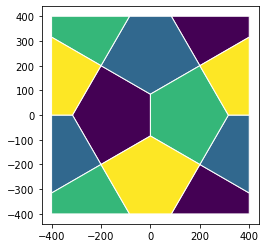

In [4]:
d = 400
tile_unit = TileUnit(spacing = d, crs = 2193)
tile = tile_unit.tile.geometry[0]

subtile = rotate(translate(tile, d, d), 30, origin = (0, 0))
subtiles = [rotate(subtile, a, origin = (0, 0)) 
            for a in range(0, 360, 90)]
subtiles = geopandas.GeoDataFrame(
    data = {"element_id": list("abcd")}, crs = 2193,
    geometry = geopandas.GeoSeries(subtiles))
subtiles = tile_unit.tile.overlay(subtiles)
subtiles = gridify(subtiles.geometry)
subtiles1 = subtiles.translate(-d, -d)
subtiles2 = subtiles1.scale(-1, 1, origin = (0, 0))
subtiles3 = subtiles2.scale(1, -1, origin = (0, 0))
subtiles4 = subtiles1.scale(1, -1, origin = (0, 0))

cairo_tile = geopandas.GeoSeries(
    list(subtiles1) + list(subtiles2) + list(subtiles3) + list(subtiles4))
cairo_unit = geopandas.GeoDataFrame(
    data = {"element_id": list("abcdcbadcdabadcb")}, crs = 2193,
    geometry = cairo_tile
)
cairo_unit.geometry = cairo_unit.geometry.scale(
    0.5/0.999, 0.5/0.999, origin = (0, 0))
cairo_unit = cairo_unit.dissolve(by = "element_id", as_index = False)
cairo_unit.plot(column = "element_id", edgecolor = "w", cmap = "viridis")


In [7]:
tile_unit.elements = cairo_unit
tiling = Tiling(tile_unit, ak, id_var = "DZ2018")
t30 = tiling.get_tiled_map()

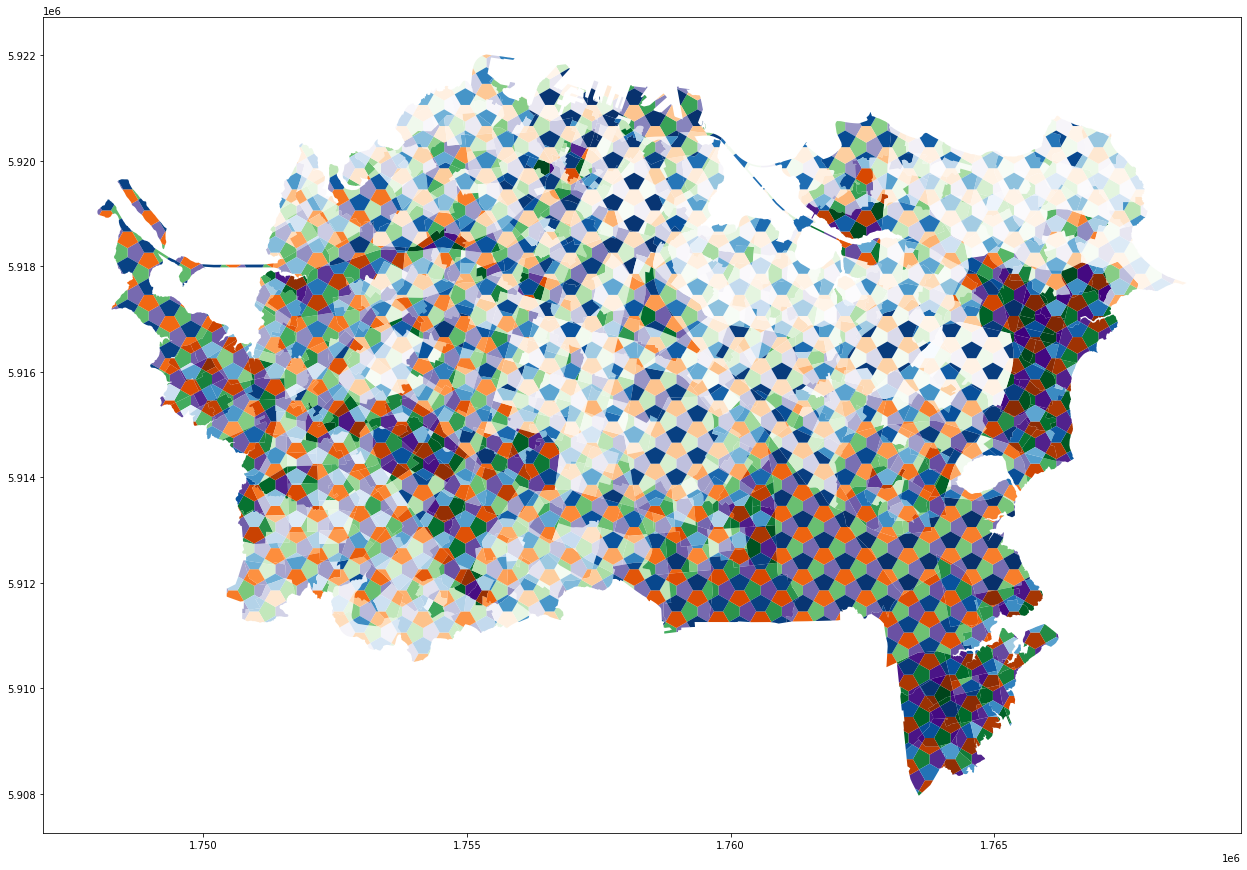

In [8]:
fig = pyplot.figure(figsize = (24, 15))
ax = fig.add_subplot(111)

strands = set(t30.element_id)
cols = [x for x in t30.columns if "Rank" in x]
cmaps = ("Purples", "Greens", "Oranges", "Blues")

for strand, col, cmap in zip(strands, cols, cmaps):
    t30[t30.element_id == strand].plot(ax = ax, column = col, cmap = cmap)